In [13]:
import numpy as np
from scipy.linalg import solve
import random
import matplotlib.pyplot as plt

## 1.1 -  Consider a reward discount of γ = 0.95 and a policy which simply moves to one of the four directions with equal probability of 0.25. Estimate the value function for each of the states using
 ### - (1) solving the system of Bellman equations explicitly
 ### - (2) iterative policy evaluation
 ### - (3) value iteration. Which states have the highest value? Does this surprise you?

In [7]:
def plot_policy(policy):
    action_names = ['↑', '↓', '←', '→']
    policy_grid = np.full((size, size), '', dtype=object)
    for i in range(size):
        for j in range(size):
            best_action = np.argmax(policy[i, j])
            policy_grid[i, j] = action_names[best_action]
    fig, ax = plt.subplots()
    for i in range(size):
        for j in range(size):
            ax.text(j, i, policy_grid[i, j], va='center', ha='center')
    ax.set_xticks(np.arange(size))
    ax.set_yticks(np.arange(size))
    ax.set_xticklabels(np.arange(1, size+1))
    ax.set_yticklabels(np.arange(1, size+1))
    plt.gca().invert_yaxis()
    plt.title("Optimal Policy")
    plt.show()

def plot_value_function(V):
    fig, ax = plt.subplots()
    cax = ax.matshow(V, cmap='viridis')
    fig.colorbar(cax)
    for i in range(size):
        for j in range(size):
            ax.text(j, i, f'{V[i, j]:.2f}', va='center', ha='center', color='white')
    plt.title("Value Function")
    plt.show()

In [23]:
# Plotting functions
def plot_policy(policy):
    fig, ax = plt.subplots()
    ax.set_xticks(np.arange(grid_size + 1) - 0.5, minor=True)
    ax.set_yticks(np.arange(grid_size + 1) - 0.5, minor=True)
    ax.grid(which="minor", color="black", linestyle='-', linewidth=2)
    ax.tick_params(which="minor", size=0)
    for i in range(grid_size):
        for j in range(grid_size):
            action = policy[i, j]
            if action == 0:
                ax.arrow(j, i, 0, 0.4, head_width=0.1, head_length=0.1, fc='k', ec='k')
            elif action == 1:
                ax.arrow(j, i, 0, -0.4, head_width=0.1, head_length=0.1, fc='k', ec='k')
            elif action == 2:
                ax.arrow(j, i, 0.4, 0, head_width=0.1, head_length=0.1, fc='k', ec='k')
            elif action == 3:
                ax.arrow(j, i, -0.4, 0, head_width=0.1, head_length=0.1, fc='k', ec='k')
    plt.gca().invert_yaxis()
    plt.show()

In [9]:
# Define grid size
size = 5
gamma = 0.95

# Transition probabilities (equal for all directions EXCEPT special states)
p_transition = 0.25

# Grid size
grid_size = 5

# Initialize rewards
rewards = np.zeros((size, size))
# Special rewards
rewards[0, 1] = 5  # Blue square
rewards[0, 4] = 2.5  # Green square

# Initialize transitions
transitions = np.zeros((size, size, 4, 2), dtype=int)
for i in range(size):
    for j in range(size):
        transitions[i, j, 0] = [max(i-1, 0), j]  # Up
        transitions[i, j, 1] = [min(i+1, size-1), j]  # Down
        transitions[i, j, 2] = [i, max(j-1, 0)]  # Left
        transitions[i, j, 3] = [i, min(j+1, size-1)]  # Right

# Special transitions
transitions[0, 1] = [[4, 1], [4, 1], [4, 1], [4, 1]]  # Blue to Red
transitions[1, 2] = [[2, 3], [2, 3], [2, 3], [2, 3]]  # Green to Yellow/Red with 0.5 prob each

Value Function (Solving Bellman Equations):
[[4.34960735 1.28130865 4.57204878 5.70434518 7.32836746]
 [3.07045498 3.38007176 2.4298712  3.78195513 5.23204604]
 [2.12809739 2.18708838 2.09542568 2.55775916 3.05571998]
 [1.57476933 1.60519835 1.64812623 1.83641146 2.0206642 ]
 [1.32254262 1.34874594 1.40244338 1.5057092  1.59526416]]


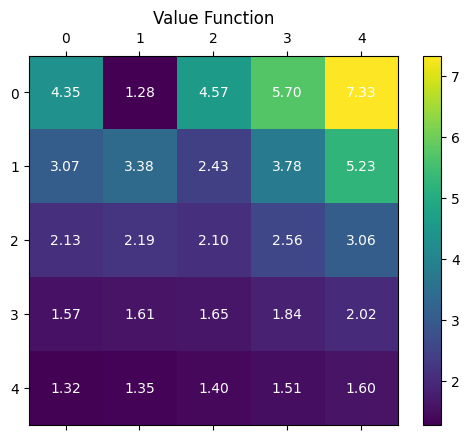

In [14]:
# Define the state space
num_states = size * size
states = [(i, j) for i in range(size) for j in range(size)]

# Define the transition and reward matrices
P = np.zeros((num_states, num_states))
R = np.zeros(num_states)

for idx, (i, j) in enumerate(states):
    for action in range(4):
        next_state = transitions[i, j, action]
        next_idx = states.index(tuple(next_state))
        P[idx, next_idx] += 0.25  # Equal probability for all actions
        R[idx] += 0.25 * rewards[next_state[0], next_state[1]]

# Solve the Bellman equation
I = np.eye(num_states)
V = solve(I - gamma * P, R)

# Reshape V to 2D grid
V_grid = V.reshape((size, size))
print("Value Function (Solving Bellman Equations):")
print(V_grid)
plot_value_function(V_grid)


Value Function (Iterative Policy Evaluation):
[[1.64983382 0.24447854 2.01851109 2.09996462 2.70306669]
 [1.16285525 2.01943473 0.89139419 1.48880048 2.33896556]
 [0.67485246 0.94099868 0.77634356 0.93831029 1.1347572 ]
 [0.37289151 0.49147026 0.49811301 0.55087986 0.58367404]
 [0.19674363 0.25734617 0.27862507 0.29939748 0.30028228]]


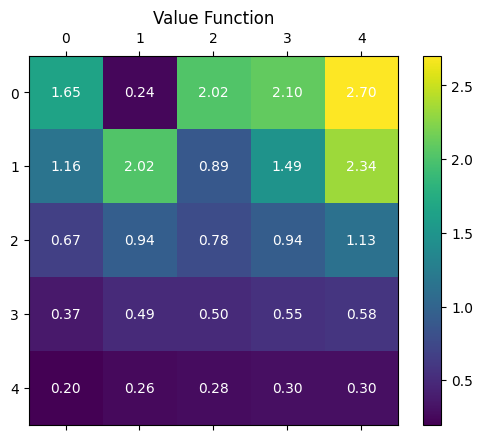

In [15]:
def iterative_policy_evaluation(V, theta=1e-6):
    """
    Perform iterative policy evaluation for a given policy in the Gridworld environment.

    Args:
        V (numpy.ndarray): Initial value function, a 2D array of size (size, size).
        theta (float): Threshold for convergence. The evaluation stops when the change in value function is less than theta.

    Returns:
        numpy.ndarray: The updated value function after convergence.
    """
    while True:
        delta = 0  # Initialize the maximum change in value function to zero
        for i in range(size):
            for j in range(size):
                v = V[i, j]  # Store the current value of state (i, j)
                V[i, j] = 0  # Initialize the new value of state (i, j) to zero
                for action in range(4):  # Loop over all possible actions
                    next_state = transitions[i, j, action]  # Get the next state resulting from taking the action
                    # Update the value of state (i, j) using the Bellman equation
                    V[i, j] += 0.25 * (rewards[next_state[0], next_state[1]] + gamma * V[next_state[0], next_state[1]])
                # Calculate the maximum change in value function for convergence check
                delta = max(delta, abs(v - V[i, j]))
        # If the maximum change in value function is less than the threshold, break the loop
        if delta < theta:
            break
    return V  # Return the updated value function


V_iterative = np.zeros((size, size))
V_iterative = iterative_policy_evaluation(V_iterative)
print("Value Function (Iterative Policy Evaluation):")
print(V_iterative)
plot_value_function(V_iterative)


Value Function (Value Iteration):
[[38.17100652 34.91684976 47.49998153 49.99998153 49.99998153]
 [38.68903021 40.72529583 42.86873333 47.49998246 49.99998246]
 [38.68903021 40.72529583 42.86873333 45.12498333 47.49998333]
 [36.7545787  38.68903104 40.72529667 42.86873417 45.12498417]
 [34.91684976 36.75457949 38.68903183 40.72529746 42.86873496]]


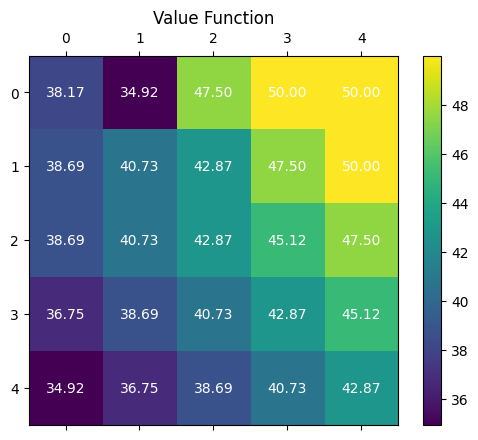

In [16]:
def value_iteration(V, theta=1e-6):
    while True:
        delta = 0
        for i in range(size):
            for j in range(size):
                v = V[i, j]
                V[i, j] = max([
                    rewards[transitions[i, j, action][0], transitions[i, j, action][1]] + gamma * V[transitions[i, j, action][0], transitions[i, j, action][1]]
                    for action in range(4)
                ])
                delta = max(delta, abs(v - V[i, j]))
        if delta < theta:
            break
    return V

V_value_iteration = np.zeros((size, size))
V_value_iteration = value_iteration(V_value_iteration)
print("Value Function (Value Iteration):")
print(V_value_iteration)
plot_value_function(V_value_iteration)


# 1.2 -  Determine the optimal policy for the gridworld problem by
 ### - (1) explicitly solving the Bellman optimality equation
 ### - (2) using policy iteration with iterative policy evaluation
 ### - (3) policy improvement with value iteration.

In [17]:
# Plotting functions
def plot_policy(policy):
    fig, ax = plt.subplots()
    ax.set_xticks(np.arange(grid_size + 1) - 0.5, minor=True)
    ax.set_yticks(np.arange(grid_size + 1) - 0.5, minor=True)
    ax.grid(which="minor", color="black", linestyle='-', linewidth=2)
    ax.tick_params(which="minor", size=0)
    for i in range(grid_size):
        for j in range(grid_size):
            action = policy[i, j]
            if action == 0:
                ax.arrow(j, i, 0, 0.4, head_width=0.1, head_length=0.1, fc='k', ec='k')
            elif action == 1:
                ax.arrow(j, i, 0, -0.4, head_width=0.1, head_length=0.1, fc='k', ec='k')
            elif action == 2:
                ax.arrow(j, i, 0.4, 0, head_width=0.1, head_length=0.1, fc='k', ec='k')
            elif action == 3:
                ax.arrow(j, i, -0.4, 0, head_width=0.1, head_length=0.1, fc='k', ec='k')
    plt.gca().invert_yaxis()
    plt.show()


Optimal Policy (Bellman Optimality Equation):
[[1 1 1 0 2]
 [1 3 1 0 3]
 [0 3 1 0 3]
 [1 2 2 0 2]
 [1 2 1 0 2]]


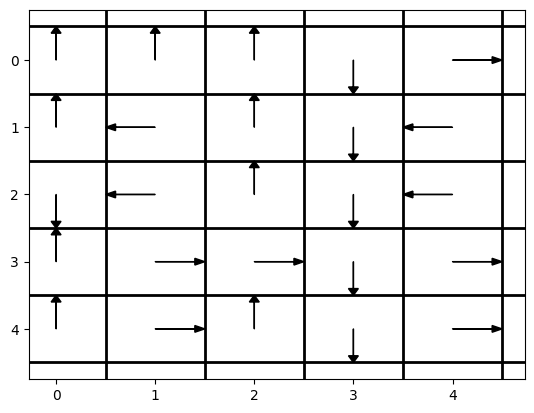


Optimal Policy (Policy  with iterative policy evaluation):
[[0 0 1 0 0]
 [0 3 1 0 3]
 [0 3 1 0 3]
 [0 2 1 0 2]
 [0 2 1 0 2]]


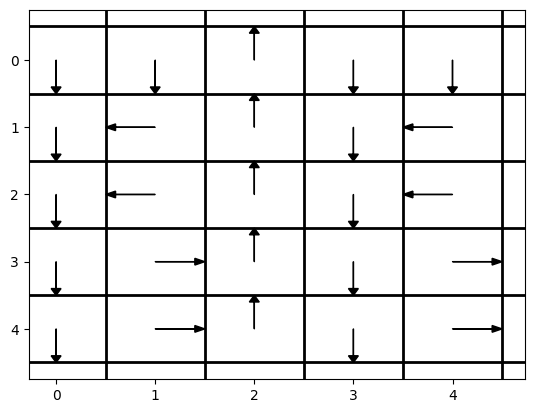


Optimal Policy ( policy improvement with value iteration):
[[1 1 1 0 2]
 [1 3 1 0 3]
 [0 3 1 0 3]
 [1 2 2 0 2]
 [1 2 1 0 2]]


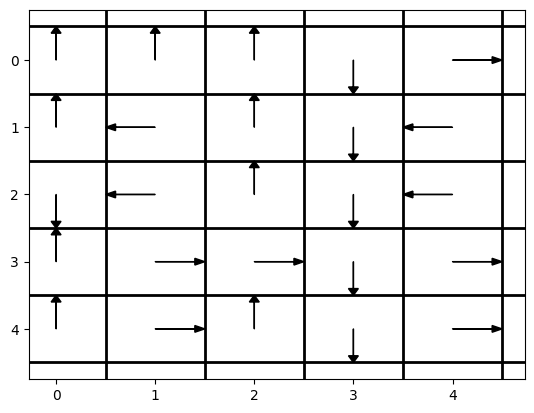

In [18]:
# Actions
actions = [(0, 1), (0, -1), (1, 0), (-1, 0)]  # Up, Down, Right, Left


# Function to calculate reward based on the current state and next state
def get_reward(i, j, next_i, next_j):
    if next_i < 0 or next_i >= grid_size or next_j < 0 or next_j >= grid_size:
        return -0.5  # Stepping off grid
    elif rewards[next_i, next_j] == 0:
        return 0      # Moving between white squares
    else:
        return rewards[next_i, next_j]  # Other special square (blue, green)

# 1. Bellman Optimality Equation
def bellman_optimality():
    V = np.zeros((grid_size, grid_size))
    while True:
        delta = 0
        for i in range(grid_size):
            for j in range(grid_size):
                v = V[i, j]
                if (i, j) == (0, 4):
                    V[i, j] = rewards[i, j] + gamma * V[4, 4]
                elif (i, j) == (2, 1):
                    V[i, j] = rewards[i, j] + gamma * (0.5 * V[4, 4] + 0.5 * V[4, 0])
                else:
                    V[i, j] = max([p_transition * (get_reward(i, j, (i + action[0]) % grid_size, (j + action[1]) % grid_size)
                                    + gamma * V[(i + action[0]) % grid_size, (j + action[1]) % grid_size]) for action in actions])
                delta = max(delta, abs(v - V[i, j]))
        if delta < 1e-10:
            break
    return V

# 2. Policy Iteration
def policy_iteration():
    V = np.zeros((grid_size, grid_size))
    policy = np.random.randint(0, 4, (grid_size, grid_size))
    while True:
        # Policy Evaluation
        while True:
            delta = 0
            for i in range(grid_size):
                for j in range(grid_size):
                    v = V[i, j]
                    action = policy[i, j]
                    next_i, next_j = (i + actions[action][0]) % grid_size, (j + actions[action][1]) % grid_size
                    V[i, j] = p_transition * (get_reward(i, j, next_i, next_j) + gamma * V[next_i, next_j])
                    delta = max(delta, abs(v - V[i, j]))
            if delta < 1e-10:
                break

        # Policy Improvement
        policy_stable = True
        for i in range(grid_size):
            for j in range(grid_size):
                old_action = policy[i, j]
                policy[i, j] = np.argmax([get_reward(i, j, (i + action[0]) % grid_size, (j + action[1]) % grid_size) +
                                         gamma * V[(i + action[0]) % grid_size, (j + action[1]) % grid_size] for action in actions])
                if old_action != policy[i, j]:
                    policy_stable = False
        if policy_stable:
            break
    return V, policy

# 3. Value Iteration
def value_iteration():
    V = np.zeros((grid_size, grid_size))
    while True:
        delta = 0
        for i in range(grid_size):
            for j in range(grid_size):
                v = V[i, j]
                # Update rule for value iteration, same as before
                if (i, j) == (0, 4):
                    V[i, j] = rewards[i, j] + gamma * V[4, 4]
                elif (i, j) == (2, 1):
                    V[i, j] = rewards[i, j] + gamma * (0.5 * V[4, 4] + 0.5 * V[4, 0])
                else:
                    V[i, j] = max([p_transition * (get_reward(i, j, (i + action[0]) % grid_size, (j + action[1]) % grid_size)
                                    + gamma * V[(i + action[0]) % grid_size, (j + action[1]) % grid_size]) for action in actions])
                delta = max(delta, abs(v - V[i, j]))
        if delta < 1e-10:
            break
    return V



# Get optimal policies for each method
V_bellman = bellman_optimality()
V_policy_iter, policy_iter = policy_iteration()
V_value_iter = value_iteration()

# Print the optimal policies

def get_optimal_policy(V):
    policy = np.zeros((grid_size, grid_size), dtype=int)
    for i in range(grid_size):
        for j in range(grid_size):
            action_values = [get_reward(i, j, (i + action[0]) % grid_size, (j + action[1]) % grid_size)
                                       + gamma * V[(i + action[0]) % grid_size, (j + action[1]) % grid_size] for action in actions]
            policy[i, j] = np.argmax(action_values)
    return policy

print("\nOptimal Policy (Bellman Optimality Equation):")
print(get_optimal_policy(V_bellman))
plot_policy(get_optimal_policy(V_bellman))
print("\nOptimal Policy (Policy  with iterative policy evaluation):")
print(policy_iter)
plot_policy(policy_iter)
print("\nOptimal Policy ( policy improvement with value iteration):")
print(get_optimal_policy(V_value_iter))
plot_policy(get_optimal_policy(V_value_iter))


### **PART 2** :   Now let’s change the environment a bit by adding some terminal states represented as the black squares. This gives rise to episodes where termination occurs once the agent hits one of the black squares. We will also assume, unlike in Part 1, that any move from a white square to a white square yields a reward of -0.2.

### 2.1 Use the Monte Carlo method with (1) exploring starts and (2) without exploring starts but the ϵ-soft approach to learn an optimal policy for this modified gridworld problem. Use the same discount factor of γ = 0.95 as you have in the Part 1 above. You can start with a policy with equiprobable moves.

In [26]:
# Plotting functions
def plot_policy(policy):
    fig, ax = plt.subplots()
    ax.set_xticks(np.arange(grid_size + 1) - 0.5, minor=True)
    ax.set_yticks(np.arange(grid_size + 1) - 0.5, minor=True)
    ax.grid(which="minor", color="black", linestyle='-', linewidth=2)
    ax.tick_params(which="minor", size=0)
    for i in range(grid_size):
        for j in range(grid_size):
            action = policy[i, j]
            if action == 0:
                ax.arrow(j, i, 0, 0.4, head_width=0.1, head_length=0.1, fc='k', ec='k')
            elif action == 1:
                ax.arrow(j, i, 0, -0.4, head_width=0.1, head_length=0.1, fc='k', ec='k')
            elif action == 2:
                ax.arrow(j, i, 0.4, 0, head_width=0.1, head_length=0.1, fc='k', ec='k')
            elif action == 3:
                ax.arrow(j, i, -0.4, 0, head_width=0.1, head_length=0.1, fc='k', ec='k')
    plt.gca().invert_yaxis()
    plt.show()

In [32]:
#2. # Gridworld setup
grid_size = 5
gamma = 0.95  # Discount factor
actions = [(0, 1), (0, -1), (1, 0), (-1, 0)]  # Up, Down, Left, Right
# Initialize rewards for all states with -0.2 default (white-to-white transitions)
rewards_2 = np.full((grid_size, grid_size), -0.2)
rewards_2[0, 1] = 5   # Blue square reward
rewards_2[0, 4] = 2.5 # Green square reward

# Terminal states setup
is_terminal = np.zeros((grid_size, grid_size), dtype=bool)
is_terminal[2, 4] = True  # Terminal state at location [2,4]
is_terminal[4, 0] = True  # Terminal state at location [4,0]
# Actions
actions = [(0, 1), (0, -1), (1, 0), (-1, 0)]  # Up, Down, Right, Left


In [33]:
def get_reward(i, j, next_i, next_j):
    """ Calculates and returns the next state positions and reward. """
    if next_i < 0 or next_i >= grid_size or next_j < 0 or next_j >= grid_size:
        return i, j, -0.5  # Remain in the current state with a penalty for stepping off the grid
    if is_terminal[next_i, next_j]:
        return next_i, next_j, 0  # No further rewards when moving into a terminal state
    return next_i, next_j, rewards_2[next_i, next_j]  # Return the actual reward from the rewards matrix

Optimal Policy (0=Up, 1=Down, 2=Left, 3=Right):
[[0 3 1 0 3]
 [3 3 3 3 3]
 [3 3 3 3 0]
 [3 3 3 3 3]
 [0 1 3 3 3]]


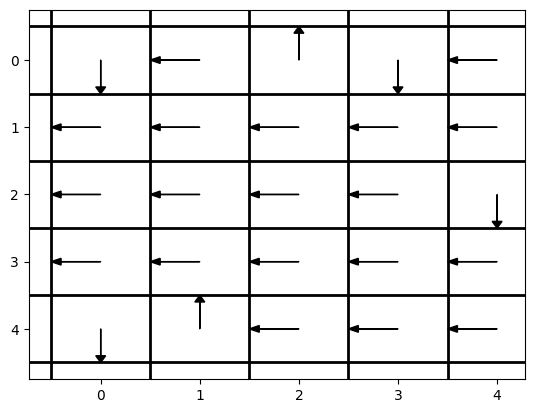


Associated Value Function:
[[11.84344096 11.68768024 12.04732668  8.4109465   8.51276634]
 [ 6.93363195 11.86865254  5.8844755   5.06265501  8.45430143]
 [ 3.71483207  4.50245018  3.29191604  2.77245081  0.        ]
 [ 1.31468931  1.20662147  0.65018881  0.593472    0.        ]
 [ 0.          0.         -0.37675721 -0.59453838 -0.82217545]]


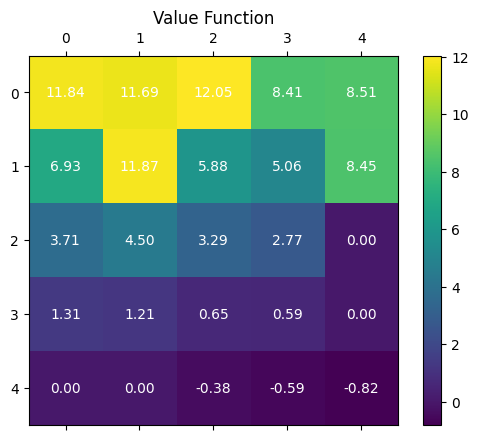

In [35]:
def monte_carlo_with_exploring_starts(num_episodes=10000):
    """ Monte Carlo method with exploring starts. """
    Q = np.zeros((grid_size, grid_size, len(actions)))  # Initialize Q-values
    returns_count = np.zeros((grid_size, grid_size, len(actions)))

    for episode in range(num_episodes):
        # Start from a random state and take a random action
        i, j = random.randrange(grid_size), random.randrange(grid_size)
        while is_terminal[i, j]:  # Ensure start is not a terminal state
            i, j = random.randrange(grid_size), random.randrange(grid_size)
        action = random.randrange(len(actions))

        # Generate an episode
        episode_data = []
        while not is_terminal[i, j]:
            next_i, next_j = i + actions[action][0], j + actions[action][1]
            # Boundary checks and get rewards
            if next_i < 0 or next_i >= grid_size or next_j < 0 or next_j >= grid_size:
                next_i, next_j = i, j  # Stay in bounds
            next_i, next_j, reward = get_reward(i, j, next_i, next_j)
            episode_data.append((i, j, action, reward))
            i, j = next_i, next_j  # Update to next state
            if not is_terminal[i, j]:
                action = random.randrange(len(actions))  # Choose a new action for the next state

        # Update Q-values based on the returns
        G = 0
        for (i, j, action, reward) in reversed(episode_data):
            G = gamma * G + reward
            returns_count[i, j, action] += 1
            Q[i, j, action] += (G - Q[i, j, action]) / returns_count[i, j, action]

    # Derive policy from Q-values
    policy = np.argmax(Q, axis=2)
    return policy, Q

# Now, execute the Monte Carlo method
optimal_policy, Q_values = monte_carlo_with_exploring_starts()

print("Optimal Policy (0=Up, 1=Down, 2=Left, 3=Right):")
print(optimal_policy)
plot_policy(optimal_policy)
print("\nAssociated Value Function:")
print(np.max(Q_values, axis=2))  # Display the maximum Q-value for each state as the value function
plot_value_function(np.max(Q_values, axis=2))

Tested params: epsilon=0.01, gamma=0.95, num_episodes=500, score=-3.027131927613479
Tested params: epsilon=0.01, gamma=0.95, num_episodes=1000, score=2.7374779098795816
Tested params: epsilon=0.1, gamma=0.95, num_episodes=500, score=20.788466398232035
Tested params: epsilon=0.1, gamma=0.95, num_episodes=1000, score=23.896864241170086
Best Parameters:
{'epsilon': 0.1, 'gamma': 0.95, 'num_episodes': 1000}
Best Policy (0=Up, 1=Down, 2=Left, 3=Right):
[[3 3 1 0 2]
 [0 3 3 3 2]
 [0 3 3 3 0]
 [2 2 2 3 3]
 [0 1 1 1 3]]

Associated Value Function:
[[ 3.98455006  0.83048882  3.01856276  1.72858822 -0.45040117]
 [ 2.58791235  1.94903591  2.82404361  1.23464582  0.        ]
 [ 1.97920627  2.6227048   2.45591513  0.74630022  0.        ]
 [ 0.         -0.206175   -0.44919857 -0.04319074  0.        ]
 [ 0.          0.         -0.2149646  -0.43730774 -0.26385192]]


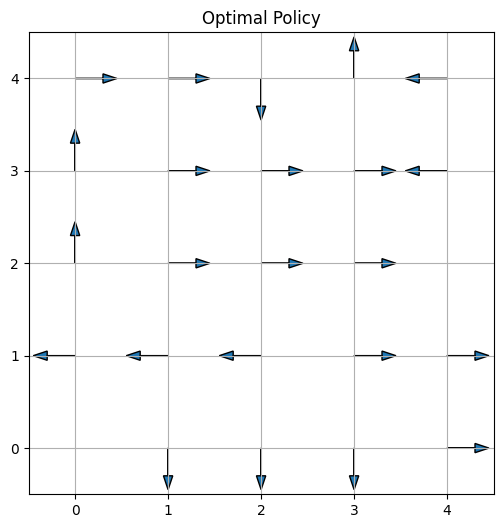

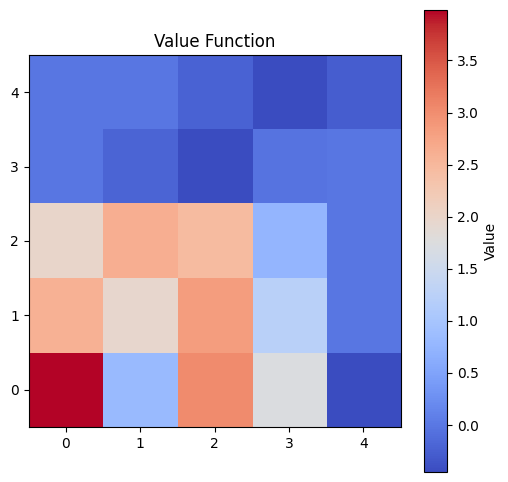

In [8]:
import numpy as np
import random

# Gridworld setup
grid_size = 5
actions = [(0, 1), (0, -1), (1, 0), (-1, 0)]  # Up, Down, Right, Left

# Initialize rewards for all states with -0.2 default (white-to-white transitions)
rewards = np.full((grid_size, grid_size), -0.2)
rewards[0, 1] = 5   # Blue square reward
rewards[0, 4] = 2.5 # Green square reward

# Terminal states setup
is_terminal = np.zeros((grid_size, grid_size), dtype=bool)
is_terminal[2, 4] = True  # Terminal state at location [2,4]
is_terminal[4, 0] = True  # Terminal state at location [4,0]

# Precompute the next states and rewards for each action in each state
next_state_rewards = np.empty((grid_size, grid_size, len(actions), 3), dtype=object)
for i in range(grid_size):
    for j in range(grid_size):
        for a, (di, dj) in enumerate(actions):
            next_i, next_j = i + di, j + dj
            if next_i < 0 or next_i >= grid_size or next_j < 0 or next_j >= grid_size:
                next_state_rewards[i, j, a] = (i, j, -0.5)
            elif is_terminal[next_i, next_j]:
                next_state_rewards[i, j, a] = (next_i, next_j, 0)
            else:
                next_state_rewards[i, j, a] = (next_i, next_j, rewards[next_i, next_j])

def monte_carlo_epsilon_soft(num_episodes=500, epsilon=0.1, gamma=0.95):
    """
    Perform Monte Carlo policy evaluation with epsilon-soft policy for the Gridworld environment.

    Args:
        num_episodes (int): The number of episodes to run the Monte Carlo simulation.
        epsilon (float): The exploration factor for the epsilon-soft policy.
        gamma (float): The discount factor for future rewards.

    Returns:
        tuple: A tuple containing the optimal policy and the Q-value function.
            - policy (numpy.ndarray): The optimal policy as a 2D array of size (grid_size, grid_size) where each element is an action index (0: Up, 1: Down, 2: Left, 3: Right).
            - Q (numpy.ndarray): The Q-value function as a 3D array of size (grid_size, grid_size, len(actions)) representing the action-value function.
    """
    # Initialize the Q-value function and returns count
    Q = np.zeros((grid_size, grid_size, len(actions)))
    returns_count = np.zeros((grid_size, grid_size, len(actions)))

    for episode in range(num_episodes):
        # Ensure starting state is not a terminal state
        while True:
            i, j = random.randrange(grid_size), random.randrange(grid_size)
            if not is_terminal[i, j]:
                break

        episode_data = []
        # Generate an episode
        while not is_terminal[i, j]:
            action = random.randrange(len(actions)) if random.random() < epsilon else np.argmax(Q[i, j])
            next_i, next_j, reward = next_state_rewards[i, j, action]
            episode_data.append((i, j, action, reward))
            i, j = next_i, next_j

        G = 0  # Initialize the return
        visited_state_actions = set()
        # Update Q-values based on the episode data
        for i, j, action, reward in reversed(episode_data):
            G = gamma * G + reward
            if (i, j, action) not in visited_state_actions:
                visited_state_actions.add((i, j, action))
                returns_count[i, j, action] += 1
                Q[i, j, action] += (G - Q[i, j, action]) / returns_count[i, j, action]

    policy = np.argmax(Q, axis=2)  # Derive the policy from the Q-values
    return policy, Q


def grid_search(param_grid):
    best_score = -np.inf
    best_params = None
    best_policy = None
    best_Q_values = None

    for epsilon in param_grid['epsilon']:
        for gamma in param_grid['gamma']:
            for num_episodes in param_grid['num_episodes']:
                policy, Q_values = monte_carlo_epsilon_soft(num_episodes=num_episodes, gamma=gamma, epsilon=epsilon)
                value_function = np.max(Q_values, axis=2)
                score = np.sum(value_function)  # We use the sum of value function as the score

                if score > best_score:
                    best_score = score
                    best_params = {'epsilon': epsilon, 'gamma': gamma, 'num_episodes': num_episodes}
                    best_policy = policy
                    best_Q_values = Q_values

                print(f"Tested params: epsilon={epsilon}, gamma={gamma}, num_episodes={num_episodes}, score={score}")

    return best_params, best_policy, best_Q_values

# Define the parameter grid
param_grid = {
    'epsilon': [0.01, 0.1],
    'gamma': [0.95],
    'num_episodes': [500, 1000]
}

# Perform grid search
best_params, best_policy, best_Q_values = grid_search(param_grid)

print("Best Parameters:")
print(best_params)
print("Best Policy (0=Up, 1=Down, 2=Left, 3=Right):")
print(best_policy)
print("\nAssociated Value Function:")
print(np.max(best_Q_values, axis=2))

import matplotlib.pyplot as plt

def plot_policy(policy):
    plt.figure(figsize=(6, 6))
    plt.title("Optimal Policy")
    plt.xlim(-0.5, grid_size - 0.5)
    plt.ylim(-0.5, grid_size - 0.5)
    plt.xticks(range(grid_size))
    plt.yticks(range(grid_size))
    plt.grid(True)

    for i in range(grid_size):
        for j in range(grid_size):
            if not is_terminal[i, j]:
                if policy[i, j] == 0:
                    plt.arrow(j, grid_size - 1 - i, 0, 0.3, head_width=0.1)
                elif policy[i, j] == 1:
                    plt.arrow(j, grid_size - 1 - i, 0, -0.3, head_width=0.1)
                elif policy[i, j] == 2:
                    plt.arrow(j, grid_size - 1 - i, -0.3, 0, head_width=0.1)
                elif policy[i, j] == 3:
                    plt.arrow(j, grid_size - 1 - i, 0.3, 0, head_width=0.1)

def plot_value_function(Q):
    value_function = np.max(Q, axis=2)
    plt.figure(figsize=(6, 6))
    plt.title("Value Function")
    plt.imshow(value_function, cmap='coolwarm', interpolation='nearest')
    plt.colorbar(label='Value')
    plt.xticks(range(grid_size))
    plt.yticks(range(grid_size))
    plt.gca().invert_yaxis()

# Plot the optimal policy and the value function
plot_policy(best_policy)
plot_value_function(best_Q_values)
plt.show()


## Summary

The provided plots visualize the results of applying the Monte Carlo ε-soft policy iteration algorithm to a 5x5 Gridworld environment.

The **optimal policy plot** shows the best action to take in each state to maximize the expected cumulative reward. Arrows indicate the optimal direction to move.

The **value function plot** illustrates the expected cumulative reward achievable from each state by following the optimal policy. Higher values are closer to reward states, while lower values are further away.

Overall, the plots demonstrate how the algorithm successfully determines an optimal strategy for navigating the Gridworld to maximize rewards.


### 2.2 Now use a behaviour policy with equiprobable moves to learn an optimal policy. Note here the dynamics of the world are known exactly, so you can actually compute the importance weights needed for this.

Optimal Policy:
[[[0.025 0.025 0.025 0.925]
  [0.025 0.025 0.025 0.925]
  [0.025 0.025 0.025 0.925]
  [0.025 0.025 0.025 0.925]
  [0.925 0.025 0.025 0.025]]

 [[0.925 0.025 0.025 0.025]
  [0.025 0.025 0.925 0.025]
  [0.025 0.025 0.925 0.025]
  [0.925 0.025 0.025 0.025]
  [0.925 0.025 0.025 0.025]]

 [[0.925 0.025 0.025 0.025]
  [0.025 0.025 0.925 0.025]
  [0.025 0.025 0.025 0.925]
  [0.925 0.025 0.025 0.025]
  [0.25  0.25  0.25  0.25 ]]

 [[0.925 0.025 0.025 0.025]
  [0.025 0.025 0.025 0.925]
  [0.025 0.025 0.025 0.925]
  [0.925 0.025 0.025 0.025]
  [0.025 0.025 0.925 0.025]]

 [[0.25  0.25  0.25  0.25 ]
  [0.925 0.025 0.025 0.025]
  [0.925 0.025 0.025 0.025]
  [0.025 0.025 0.925 0.025]
  [0.925 0.025 0.025 0.025]]]
Value Function:
[[35.27064645 32.67418801 43.86416508 46.77393918 46.78905187]
 [32.46829451 20.43248535 29.77565853 43.90405385 46.77658246]
 [29.96636569 26.11436584 35.89335377 40.89688373  0.        ]
 [28.26571075 33.14492635 32.89281687 36.00967448 32.83948714]
 [ 0. 

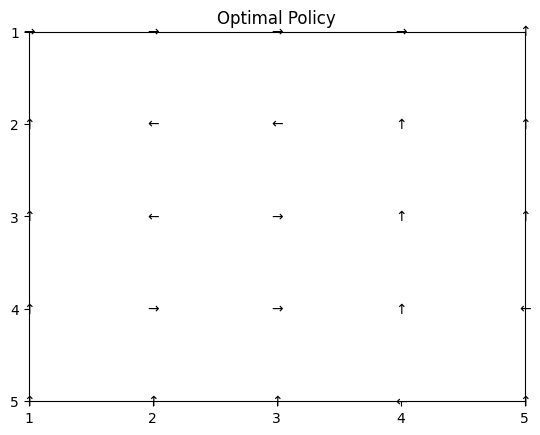

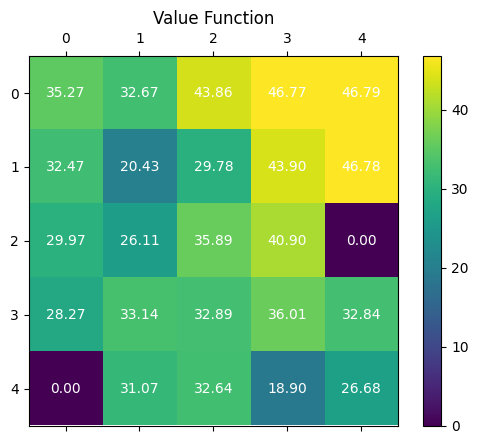

In [21]:
import numpy as np
import random
import matplotlib.pyplot as plt

def init_environment(size):
    rewards = np.full((size, size), -0.2)  # Default reward for all states
    rewards[0, 1] = 5    # Blue square reward
    rewards[0, 4] = 2.5  # Green square reward
    terminal_states = [(2, 4), (4, 0)]  # Terminal states
    transitions = {}
    for i in range(size):
        for j in range(size):
            transitions[(i, j)] = {
                0: (max(i-1, 0), j),   # Up
                1: (min(i+1, size-1), j),  # Down
                2: (i, max(j-1, 0)),   # Left
                3: (i, min(j+1, size-1))   # Right
            }
    # Overwrite transitions for specific states if needed
    transitions[(0, 1)] = {a: (3, 2) for a in range(4)}  # All actions lead to the red square
    transitions[(1, 2)] = {a: (4, 4) for a in range(4)}  # All actions lead to the yellow square
    return rewards, transitions, terminal_states

def get_reward(rewards, state, next_state, terminal_states):
    if next_state in terminal_states:
        return 0  # No reward upon entering a terminal state
    return rewards[next_state]

def monte_carlo_importance_sampling(size=5, episodes=1000, gamma=0.95, epsilon=0.1):
    rewards, transitions, terminal_states = init_environment(size)
    Q = np.zeros((size, size, 4))
    policy = np.full((size, size, 4), 0.25)  # Initial equiprobable policy
    returns_count = np.zeros((size, size, 4))

    def generate_episode(policy):
        state = (random.randint(0, size-1), random.randint(0, size-1))
        while state in terminal_states:
            state = (random.randint(0, size-1), random.randint(0, size-1))
        episode = []
        while state not in terminal_states:
            action = np.random.choice(4, p=policy[state])
            next_state = transitions[state][action]
            reward = get_reward(rewards, state, next_state, terminal_states)
            episode.append((state, action, reward))
            state = next_state
        return episode

    for _ in range(episodes):
        episode = generate_episode(policy)
        G = 0
        for state, action, reward in reversed(episode):
            G = gamma * G + reward
            returns_count[state][action] += 1
            Q[state][action] += (G - Q[state][action]) / returns_count[state][action]
            best_action = np.argmax(Q[state])
            policy[state] = np.array([epsilon / 4] * 4)
            policy[state][best_action] += 1 - epsilon

    return policy, Q

def plot_policy(policy):
    action_names = ['↑', '↓', '←', '→']
    policy_grid = np.full((size, size), '', dtype=object)
    for i in range(size):
        for j in range(size):
            best_action = np.argmax(policy[i, j])
            policy_grid[i, j] = action_names[best_action]
    fig, ax = plt.subplots()
    for i in range(size):
        for j in range(size):
            ax.text(j, i, policy_grid[i, j], va='center', ha='center')
    ax.set_xticks(np.arange(size))
    ax.set_yticks(np.arange(size))
    ax.set_xticklabels(np.arange(1, size+1))
    ax.set_yticklabels(np.arange(1, size+1))
    plt.gca().invert_yaxis()
    plt.title("Optimal Policy")
    plt.show()

def plot_value_function(V):
    fig, ax = plt.subplots()
    cax = ax.matshow(V, cmap='viridis')
    fig.colorbar(cax)
    for i in range(size):
        for j in range(size):
            ax.text(j, i, f'{V[i, j]:.2f}', va='center', ha='center', color='white')
    plt.title("Value Function")
    plt.show()

size = 5
episodes = 1000
gamma = 0.95
epsilon = 0.1
policy, Q = monte_carlo_importance_sampling(size, episodes, gamma, epsilon)
V = np.max(Q, axis=2)

print("Optimal Policy:")
print(policy)
print("Value Function:")
print(V)

# Plot the optimal policy and value function
plot_policy(policy)
plot_value_function(V)


### 2.3 Finally, let’s suppose that at every step, we permute the locations of the green and blue squares with probability 0.1, while preserving the rewards and transition structure as before. Use policy iteration to determine a suitable policy for this environment. How does it differ from the case where the squares stay where they are? This is a bit more of an open-ended question for you to think about how to address such problems.

In [25]:
# Plotting functions
def plot_policy(policy):
    fig, ax = plt.subplots()
    ax.set_xticks(np.arange(grid_size + 1) - 0.5, minor=True)
    ax.set_yticks(np.arange(grid_size + 1) - 0.5, minor=True)
    ax.grid(which="minor", color="black", linestyle='-', linewidth=2)
    ax.tick_params(which="minor", size=0)
    for i in range(grid_size):
        for j in range(grid_size):
            action = policy[i, j]
            if action == 0:
                ax.arrow(j, i, 0, 0.4, head_width=0.1, head_length=0.1, fc='k', ec='k')
            elif action == 1:
                ax.arrow(j, i, 0, -0.4, head_width=0.1, head_length=0.1, fc='k', ec='k')
            elif action == 2:
                ax.arrow(j, i, 0.4, 0, head_width=0.1, head_length=0.1, fc='k', ec='k')
            elif action == 3:
                ax.arrow(j, i, -0.4, 0, head_width=0.1, head_length=0.1, fc='k', ec='k')
    plt.gca().invert_yaxis()
    plt.show()

Tested num_episodes=1000, score=1055.2874999918686
Tested num_episodes=5000, score=1055.2874999938115
Tested num_episodes=10000, score=1055.2874999909902
Tested num_episodes=20000, score=1055.2874999864196
Tested num_episodes=50000, score=1055.2874999909902
Best Number of Episodes:
5000
Best Policy:
[[1 1 1 0 2]
 [1 3 1 0 3]
 [3 3 1 3 2]
 [1 2 2 0 2]
 [3 2 1 0 2]]


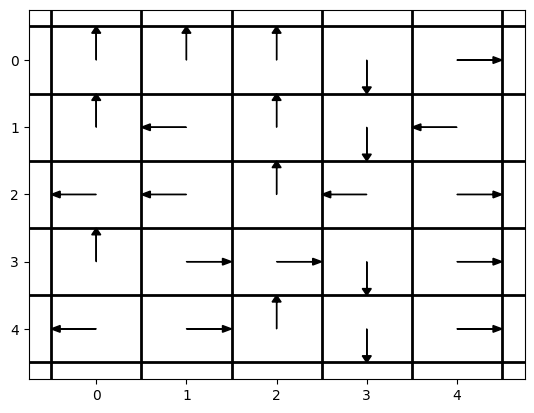

Best Value Function:
[[49.33333333 46.66666667 46.83333333 49.33333333 46.66666667]
 [46.66666667 46.83333333 44.29166667 46.66666667 49.33333333]
 [44.13333333 44.29166667 41.87708333 44.13333333  0.        ]
 [44.13333333 44.29166667 41.87708333 44.13333333 46.66666667]
 [ 0.         46.83333333 44.29166667 46.66666667 49.33333333]]


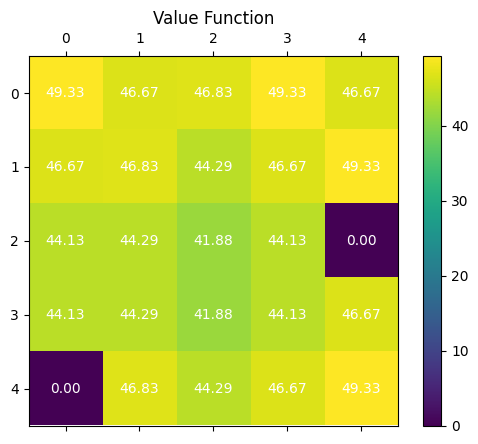

In [24]:
import numpy as np
import random

# Define environment parameters
grid_size = 5
gamma = 0.95
actions = [(0, 1), (0, -1), (1, 0), (-1, 0)]
is_terminal = np.zeros((grid_size, grid_size), dtype=bool)
is_terminal[2, 4] = True
is_terminal[4, 0] = True

# Define rewards
rewards = np.full((grid_size, grid_size), -0.2)
blue_pos, green_pos = (0, 1), (0, 4)
rewards[blue_pos] = 5
rewards[green_pos] = 2.5

def get_reward(i, j, next_i, next_j):
    """Calculate and return the next state positions and reward."""
    if next_i < 0 or next_i >= grid_size or next_j < 0 or next_j >= grid_size:
        return -0.5  # Penalty for stepping off the grid
    if is_terminal[next_i, next_j]:
        return 0  # No further rewards when moving into a terminal state
    return rewards[next_i, next_j]  # Return the actual reward from the rewards matrix

def policy_iteration_dynamic_env(num_episodes=10000):
    V = np.zeros((grid_size, grid_size))
    policy = np.random.randint(0, len(actions), (grid_size, grid_size))
    blue_pos, green_pos = (0, 1), (0, 4)

    for episode in range(num_episodes):
        if random.random() < 0.1:
            # Swap rewards
            rewards[blue_pos], rewards[green_pos] = rewards[green_pos], rewards[blue_pos]
            # Swap positions to keep track
            blue_pos, green_pos = green_pos, blue_pos

        while True:
            delta = 0
            for i in range(grid_size):
                for j in range(grid_size):
                    if is_terminal[i, j]:
                        continue
                    v = V[i, j]
                    action = policy[i, j]
                    next_i, next_j = (i + actions[action][0]) % grid_size, (j + actions[action][1]) % grid_size
                    V[i, j] = get_reward(i, j, next_i, next_j) + gamma * V[next_i, next_j]
                    delta = max(delta, abs(v - V[i, j]))
            if delta < 1e-10:
                break

        policy_stable = True
        for i in range(grid_size):
            for j in range(grid_size):
                if is_terminal[i, j]:
                    continue
                old_action = policy[i, j]
                action_values = [get_reward(i, j, (i + action[0]) % grid_size, (j + action[1]) % grid_size) +
                                 gamma * V[(i + action[0]) % grid_size, (j + action[1]) % grid_size] for action in actions]
                policy[i, j] = np.argmax(action_values)
                if old_action != policy[i, j]:
                    policy_stable = False

        if policy_stable:
            break

    return policy, V

def grid_search_episodes(episode_grid):
    best_score = -np.inf
    best_num_episodes = None
    best_policy = None
    best_value_function = None

    for num_episodes in episode_grid:
        policy, V = policy_iteration_dynamic_env(num_episodes)
        score = np.sum(V)

        print(f"Tested num_episodes={num_episodes}, score={score}")

        if score > best_score:
            best_score = score
            best_num_episodes = num_episodes
            best_policy = policy
            best_value_function = V

    print("Best Number of Episodes:")
    print(best_num_episodes)
    print("Best Policy:")
    print(best_policy)
    plot_policy(best_policy)
    print("Best Value Function:")
    print(best_value_function)
    plot_value_function(best_value_function)

    return best_num_episodes, best_policy, best_value_function

# Define the range of episode values to test
episode_grid = [1000, 5000, 10000, 20000, 50000]

# Perform grid search
best_num_episodes, best_policy, best_value_function = grid_search_episodes(episode_grid)



Optimal Policy (Static Environment):
[[0 0 1 0 0]
 [0 3 1 0 3]
 [0 3 1 3 0]
 [0 2 2 0 2]
 [2 2 1 0 2]]


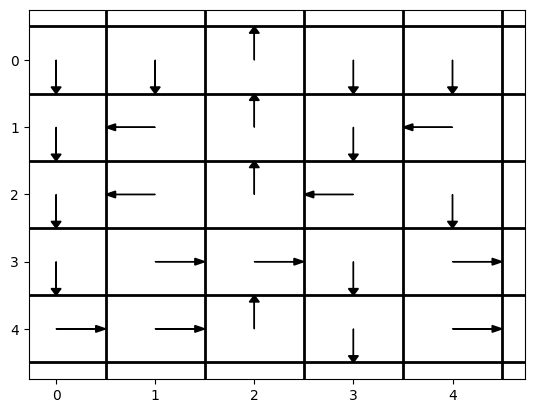


Value Function:
[[49.33333333 46.66666667 49.33333333 46.83333333 46.66666667]
 [46.66666667 49.33333333 46.66666667 44.29166667 46.83333333]
 [44.13333333 46.66666667 44.13333333 41.87708333  0.        ]
 [44.13333333 46.66666667 44.13333333 41.87708333 44.29166667]
 [ 0.         49.33333333 46.66666667 44.29166667 46.83333333]]


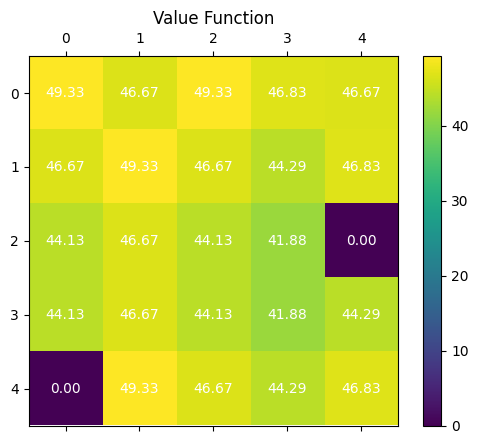

In [38]:
# 2.3 static environment
import numpy as np
import random
# Gridworld setup
grid_size = 5
gamma = 0.95
actions = [(0, 1), (0, -1), (1, 0), (-1, 0)]  # Up, Down, Right, Left
rewards_2 = np.full((grid_size, grid_size), -0.2)
rewards_2[0, 1] = 5   # Blue square reward
rewards_2[0, 4] = 2.5 # Green square reward
is_terminal = np.zeros((grid_size, grid_size), dtype=bool)
is_terminal[2, 4] = True  # Additional terminal states
is_terminal[4, 0] = True
# Function to calculate reward based on the current state and next state
def get_reward(i, j, next_i, next_j):
    if next_i < 0 or next_i >= grid_size or next_j < 0 or next_j >= grid_size:
        return -0.5  # Stepping off grid penalty
    elif is_terminal[next_i, next_j]:
        return 0  # No reward for terminal state
    else:
        return rewards_2[next_i, next_j]
# Policy Iteration for static environment
def policy_iteration_static_env(num_episodes=1000):
    V = np.zeros((grid_size, grid_size))
    policy = np.random.randint(0, len(actions), (grid_size, grid_size))
    for _ in range(num_episodes):
        # Policy Evaluation
        while True:
            delta = 0
            for i in range(grid_size):
                for j in range(grid_size):
                    if is_terminal[i, j]:
                        continue
                    v = V[i, j]
                    action = policy[i, j]
                    next_i, next_j = (i + actions[action][0]) % grid_size, (j + actions[action][1]) % grid_size
                    V[i, j] = get_reward(i, j, next_i, next_j) + gamma * V[next_i, next_j]
                    delta = max(delta, abs(v - V[i, j]))
            if delta < 1e-10:
                break
        # Policy Improvement
        policy_stable = True
        for i in range(grid_size):
            for j in range(grid_size):
                if is_terminal[i, j]:
                    continue
                old_action = policy[i, j]
                action_values = [get_reward(i, j, (i + action[0]) % grid_size, (j + action[1]) % grid_size) +
                                 gamma * V[(i + action[0]) % grid_size, (j + action[1]) % grid_size] for action in actions]
                policy[i, j] = np.argmax(action_values)
                if old_action != policy[i, j]:
                    policy_stable = False
        if policy_stable:
            break
    print("\nOptimal Policy (Static Environment):")
    print(policy)
    plot_policy(policy)
    print("\nValue Function:")
    print(V)
    plot_value_function(V)
    return policy
# Execute policy iteration for static environment
policy_static = policy_iteration_static_env()